# Phân loại nhịp tim

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plst
import keras
import os
from scipy.io import loadmat
import math

In [74]:
!pip install gdown

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [ ]:
import gdown


url = f''

# Chuyển đổi URL sang định dạng gdown
gdown.download_folder(url, quiet=False)


Retrieving folder contents


Processing file 1lnHxZeLOy7YhUMGw0Z0p7qCsvC8SlDqO sample2017.zip
Processing file 1mBAoHiRjkl4PIoFZG0i_wI9UyyflwZTX training2017.zip


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1lnHxZeLOy7YhUMGw0Z0p7qCsvC8SlDqO
To: /kaggle/working/EGC_dataset/sample2017.zip
100%|██████████| 3.58M/3.58M [00:00<00:00, 276MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1mBAoHiRjkl4PIoFZG0i_wI9UyyflwZTX
From (redirected): https://drive.google.com/uc?id=1mBAoHiRjkl4PIoFZG0i_wI9UyyflwZTX&confirm=t&uuid=81e04b86-3ae6-4ade-942f-c0a0d7ba946a
To: /kaggle/working/EGC_dataset/training2017.zip
100%|██████████| 99.2M/99.2M [00:00<00:00, 117MB/s] 
Download completed


['/kaggle/working/EGC_dataset/sample2017.zip',
 '/kaggle/working/EGC_dataset/training2017.zip']

In [76]:
import zipfile
import os

def extract_zip_file(zip_path, extract_to):
    """
    Hàm giải nén tệp zip từ đường dẫn zip_path và lưu vào thư mục extract_to.
    
    :param zip_path: Địa chỉ tệp zip cần giải nén.
    :param extract_to: Địa chỉ thư mục để giải nén các tệp.
    """
    # Kiểm tra xem tệp zip có tồn tại không
    if not os.path.exists(zip_path):
        print(f"Tệp zip {zip_path} không tồn tại.")
        return
    
    # Giải nén tệp zip
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
        print(f"Tệp đã được giải nén vào {extract_to}")

# Ví dụ sử dụng
# sample2017.zip
# training2017.zip
# zip_path = '/kaggle/working/EGC_dataset/sample2017.zip'
zip_path = '/kaggle/working/EGC_dataset/training2017.zip'
extract_to = '/kaggle/working/EGC_dataset_2017'
extract_zip_file(zip_path, extract_to)


Tệp đã được giải nén vào /kaggle/working/EGC_dataset_2017


In [77]:
def count_file_types(directory):
    """
    Hàm đếm các loại tệp trong thư mục và trả về danh sách các loại tệp và số lượng của chúng.
    
    :param directory: Địa chỉ thư mục cần kiểm tra.
    :return: Số lượng các loại tệp và danh sách các loại tệp.
    """
    file_types = {}
    
    # Duyệt qua tất cả các tệp trong thư mục
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_extension = file.split('.')[-1]  # Lấy phần mở rộng của tệp
            if file_extension in file_types:
                file_types[file_extension] += 1
            else:
                file_types[file_extension] = 1
    
    return file_types

# Địa chỉ thư mục đã giải nén
directory = '/kaggle/working/EGC_dataset_2017/training2017'

# Đếm các loại tệp trong thư mục
file_types = count_file_types(directory)

# In kết quả
print("Các loại tệp trong thư mục:")
for ext, count in file_types.items():
    print(f"{ext}: {count} tệp")

Các loại tệp trong thư mục:
mat: 8528 tệp
hea: 8528 tệp
RECORDS: 1 tệp
csv: 2 tệp


In [78]:
# Địa chỉ tệp RECORDS trong thư mục đã giải nén
records_file_path = '/kaggle/working/EGC_dataset_2017/training2017/RECORDS'
labels = []
# Đọc nội dung tệp RECORDS
try:
    with open(records_file_path, 'r') as file:
        records_content = file.read()
        print("Nội dung tệp RECORDS:\n")
        # print(records_content)
        labels.append(records_content)
except FileNotFoundError:
    print(f"Tệp {records_file_path} không tồn tại.")
except Exception as e:
    print(f"Đã xảy ra lỗi khi đọc tệp: {e}")


Nội dung tệp RECORDS:



# Xử lý label của dữ liệu

In [79]:
processed_labels = labels[0].split('\n')
processed_labels = processed_labels[0:-1]
# In kết quả
# print(processed_labels)
terms = processed_labels
print(len(terms))

8528


In [80]:
import os
import numpy as np
from scipy.io import loadmat  # Thư viện cần thiết để đọc tệp .mat

def read_ecg_files(file_id):
    """
    Đọc thông tin từ các tệp .hea, .dat, và .mat cho một file_id cụ thể và hiển thị thông tin.

    :param file_id: Tên tệp cần đọc mà không có phần mở rộng (ví dụ: 'e0103').
    """
    # Địa chỉ thư mục chứa các tệp
    base_dir = '/kaggle/working/EGC_dataset_2017/training2017/'

    # Đọc tệp .hea (header file)
    hea_file = os.path.join(base_dir, f"{file_id}.hea")
    try:
        with open(hea_file, 'r') as file:
            hea_content = file.readlines()
            print(f"Thông tin trong tệp {file_id}.hea:")
            for line in hea_content:
                print(line.strip())  # In từng dòng nội dung của tệp
    except FileNotFoundError:
        print(f"Tệp {hea_file} không tồn tại.")
    

    # Đọc tệp .mat (Dữ liệu MATLAB)
    mat_file = os.path.join(base_dir, f"{file_id}.mat")
    try:
        mat_data = loadmat(mat_file)  # Sử dụng scipy để đọc tệp .mat
        print(f"\nDữ liệu trong tệp {file_id}.mat:")
        print("Số lượng dữ liệu: ", len(mat_data["val"][0]))
        # Hiển thị các biến có trong tệp .mat
        for var_name in mat_data:
            print(f"{var_name}: {mat_data[var_name]}")
    except FileNotFoundError:
        print(f"Tệp {mat_file} không tồn tại.")
    except Exception as e:
        print(f"Lỗi khi đọc tệp .mat: {e}")

# Ví dụ sử dụng
file_id = terms[0]  # Chỉ định tệp cần đọc
read_ecg_files(file_id)


Thông tin trong tệp A00001.hea:
A00001 1 300 9000 05:05:15 1/05/2000
A00001.mat 16+24 1000/mV 16 0 -127 0 0 ECG

Dữ liệu trong tệp A00001.mat:
Số lượng dữ liệu:  9000
val: [[-127 -162 -197 ...  -18  -22  -21]]


In [81]:
labels = pd.read_csv( "/kaggle/working/EGC_dataset_2017/training2017/REFERENCE.csv")

In [82]:
labels

,A00001,N
0,A00002,N
1,A00003,N
2,A00004,A
3,A00005,A
4,A00006,N
...,...,...
8522,A08524,N
8523,A08525,O
8524,A08526,N
8525,A08527,N


# Xem cac label trong dữ liệu

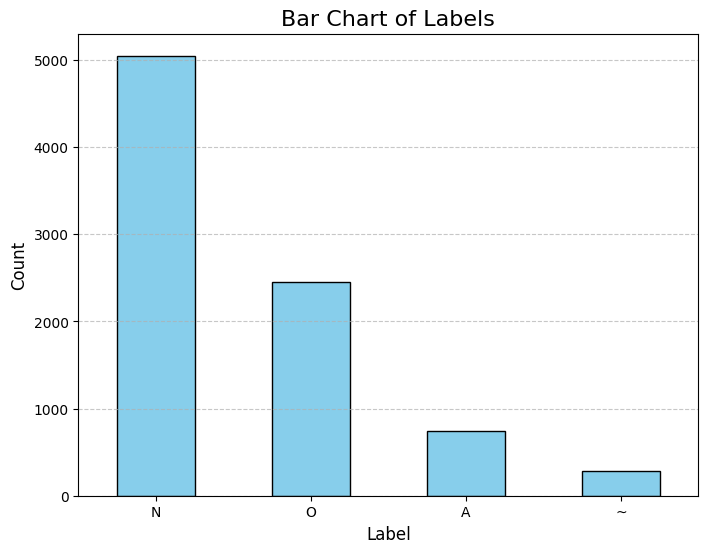

In [83]:

import matplotlib.pyplot as plt
label_counts = labels['N'].value_counts()

# Vẽ biểu đồ cột
plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Bar Chart of Labels', fontsize=16)
plt.xlabel('Label', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

N (Normal beat): Nhịp tim bình thường.

O (Other beat): Các nhịp tim khác không thuộc các loại nhịp đặc trưng.

A (Atrial fibrillation): Rung nhĩ.

~ (Noisy signal): Tín hiệu nhiễu hoặc không thể phân loại được.

# Lấy tất cả các label có trong dữ liệu

In [84]:
def get_labels():
    dir = '/kaggle/working/EGC_dataset_2017/training2017/'
    label = pd.read_csv(dir + 'REFERENCE.csv')
    label = label.values.tolist() # --> convert test dataframe to list
    # print(label)
    y = np.array([])
    file = []
    for t in label:
            # print(t[1])
            y = np.append(y,t[1])
            file.append(t[0])
        # print(x)
    return y,file


    

In [85]:
# # print(r)
#         test = pd.read_csv(dir + r)
#         test = test.values.tolist() # --> convert test dataframe to list

#         # print(r)
#         if len(test)==9000 :
#             for char in '.csv':  
#                 r = r.replace(char,'')  
#             # print(r)
#             x = np.array([])
#             for t in test:
#                 # print(t[1])
#                 x = np.append(x,t[1])
#             # print(x)
#             x_train = np.append(x_train,x)
#             # print(x_train,counter)
#             # TODO : add switch mode eg: N --> 0 etc
#             y_train = np.append(y_train,y[f.index(r)])
#             file = np.append(file,r)
#             counter = counter + 1


#     x_train = x_train.reshape(counter, 9000)
#     for i in range(0, counter):
#         print(file[i],y_train[i])
    

In [86]:
def load_data():
    dir = '/kaggle/working/EGC_dataset_2017/training2017/'
    counter = 0

    # Lấy nhãn và danh sách file từ REFERENCE.csv
    y, f = get_labels()

    # Khởi tạo x_train, y_train
    x_train = []
    y_train = []

    # Duyệt qua từng file ID trong danh sách
    for i, file_id in enumerate(f):
        mat_file = os.path.join(dir, f"{file_id}.mat")  # Đường dẫn tới file .mat

        # Kiểm tra tệp có tồn tại không
        if os.path.exists(mat_file):
            try:
                # Đọc dữ liệu từ tệp .mat
                mat_data = loadmat(mat_file)

                # Lấy tín hiệu ECG từ biến "val"
                ecg_signal = mat_data["val"][0]  # Lấy hàng đầu tiên chứa tín hiệu

                # Kiểm tra độ dài tín hiệu (chỉ lấy tín hiệu đủ 9000 mẫu)
                if len(ecg_signal) == 9000:
                    x_train.append(ecg_signal)          # Thêm tín hiệu vào x_train
                    y_train.append(y[i])               # Thêm nhãn tương ứng vào y_train
                    counter += 1
                else:
                    # print(f"Tệp {file_id}.mat có độ dài tín hiệu không đủ 9000 mẫu.")
                    pass

            except Exception as e:
                print(f"Lỗi khi xử lý tệp {file_id}.mat: {e}")
        else:
            print(f"Tệp {file_id}.mat không tồn tại.")

    # Chuyển đổi x_train, y_train sang numpy array
    x_train = np.array(x_train)
    y_train = np.array(y_train)

    print(f"Tổng số tín hiệu hợp lệ: {counter}")
    return x_train, y_train

# ************************** End of Function *****************************************************

x_train, y_train = load_data()

print("Kích thước x_train:", x_train.shape)
print("Kích thước y_train:", y_train.shape)
print("Kết thúc")


Tổng số tín hiệu hợp lệ: 5976
Kích thước x_train: (5976, 9000)
Kích thước y_train: (5976,)
Kết thúc


# Vẽ biểu đồ y_train

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


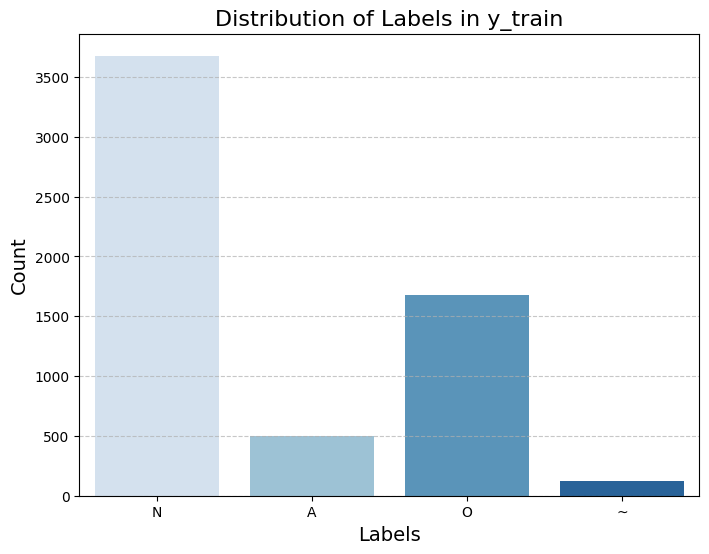

In [87]:
# Re-import libraries and recreate the data (since execution state was reset)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter


# Count the occurrences of each label in y_train
label_counts = Counter(y_train)

# Plot bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()), palette="Blues")
plt.xlabel("Labels", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title("Distribution of Labels in y_train", fontsize=16)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [88]:
x_train

array([[ 128,  157,  189, ...,    0,    1,    2],
       [ 519,  619,  723, ...,  116,   17,   18],
       [-266, -316, -367, ...,   51,   34,   21],
       ...,
       [-121, -197, -288, ...,  -96,  -77,  -59],
       [-227, -297, -374, ...,  -54,  -44,  -36],
       [-237, -286, -338, ...,  -16,  -17,  -18]], dtype=int16)

In [89]:
X_train = x_train.copy()

In [90]:
X_train

array([[ 128,  157,  189, ...,    0,    1,    2],
       [ 519,  619,  723, ...,  116,   17,   18],
       [-266, -316, -367, ...,   51,   34,   21],
       ...,
       [-121, -197, -288, ...,  -96,  -77,  -59],
       [-227, -297, -374, ...,  -54,  -44,  -36],
       [-237, -286, -338, ...,  -16,  -17,  -18]], dtype=int16)

In [91]:
# pip install neurokit2

Processing signal 1/5976 with label: N


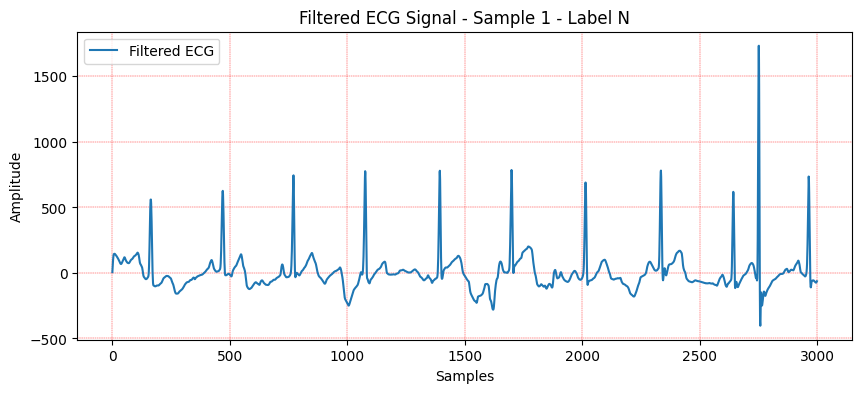

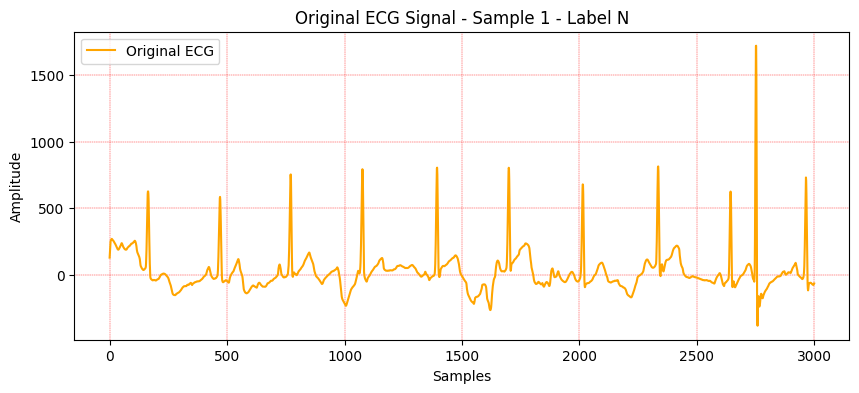

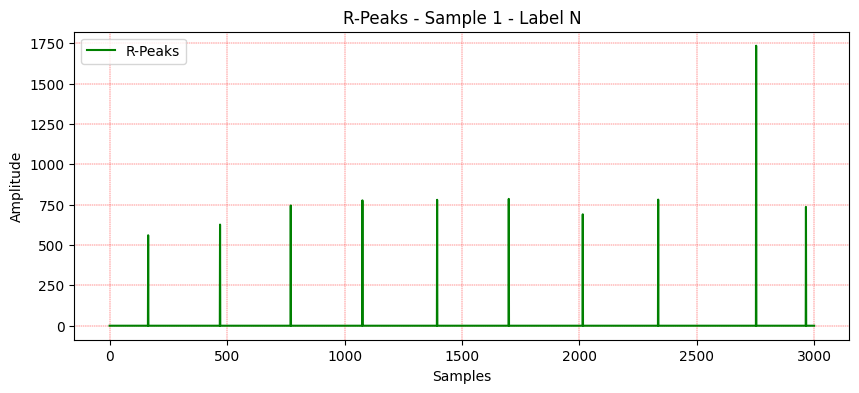

Processing signal 2/5976 with label: A


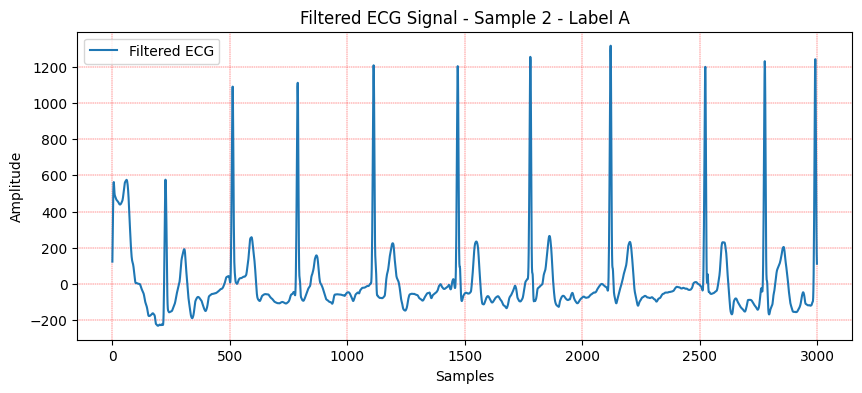

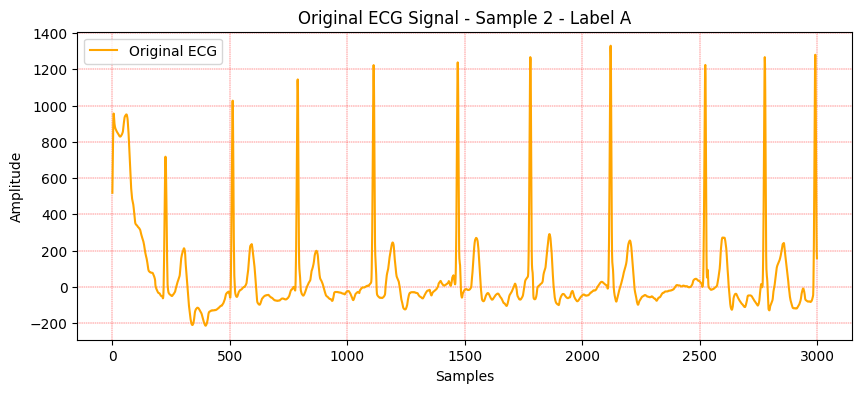

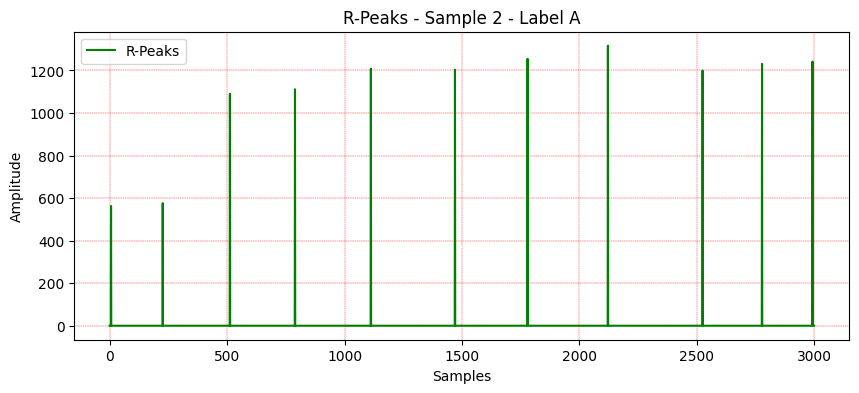

Processing signal 3/5976 with label: N


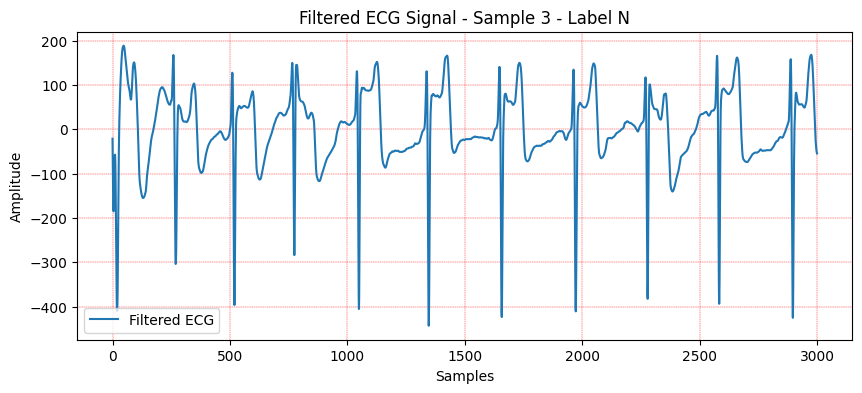

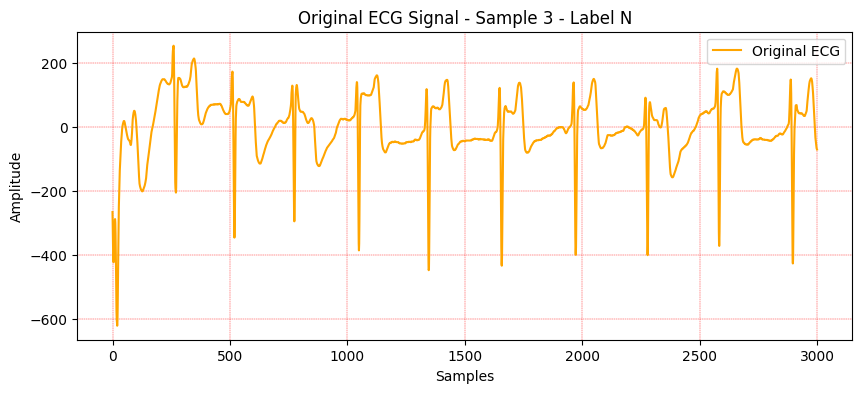

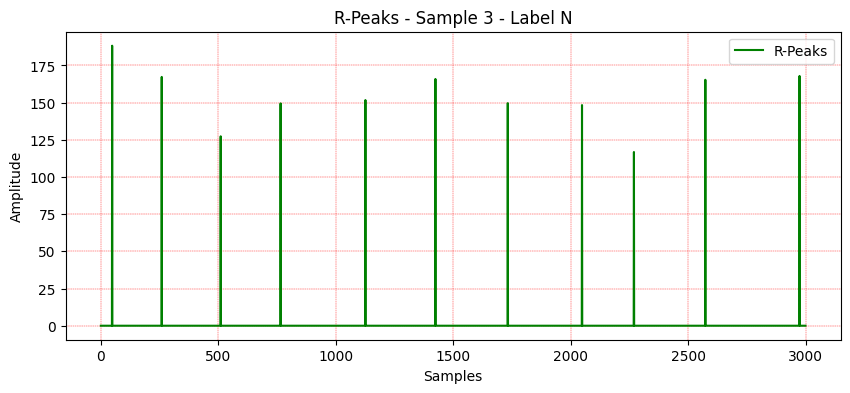

In [92]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks

# Hàm lọc tín hiệu ECG
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order)
    y = filtfilt(b, a, data)
    return y

# Parameters
samples = 3000  # Số lượng mẫu để hiển thị
sampling_rate = 300  # Tần số lấy mẫu (Hz)
lowcut = 0.5  # Tần số thấp cho bộ lọc (Hz)
highcut = 50.0  # Tần số cao cho bộ lọc (Hz)

# Vòng lặp qua tất cả tín hiệu trong X_train
for i, ecg_signal in enumerate(X_train):
    # Lấy nhãn tương ứng
    label = y_train[i]
    
    # Chuyển đổi tín hiệu sang định dạng float nếu cần thiết
    ecg_signal = ecg_signal.astype(float)

    # Hiển thị thông tin mẫu
    print(f"Processing signal {i + 1}/{len(X_train)} with label: {label}")
    
    # Lọc tín hiệu ECG (Thay thế cho nk.ecg_clean)
    ecg_cleaned = bandpass_filter(ecg_signal, lowcut, highcut, sampling_rate)
    
    # Vẽ tín hiệu đã lọc
    plt.figure(figsize=(10, 4))
    plt.plot(ecg_cleaned[0:samples], label="Filtered ECG")
    plt.title(f"Filtered ECG Signal - Sample {i + 1} - Label {label}")
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(color='r', linestyle='--', linewidth=0.3)
    plt.show()
    
    # Vẽ tín hiệu gốc
    plt.figure(figsize=(10, 4))
    plt.plot(ecg_signal[0:samples], label="Original ECG", color='orange')
    plt.title(f"Original ECG Signal - Sample {i + 1} - Label {label}")
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(color='r', linestyle='--', linewidth=0.3)
    plt.show()

    # ================================ Find R-Peaks ==================================================
    # Tìm các R-peaks bằng hàm find_peaks từ scipy
    r_peaks, _ = find_peaks(ecg_cleaned, distance=sampling_rate*0.6, height=0.5)  # Tìm đỉnh với khoảng cách phù hợp
    
    # Tạo tín hiệu chứa R-peaks
    r = np.zeros_like(ecg_cleaned)
    r[r_peaks] = ecg_cleaned[r_peaks]

    # Vẽ R-peaks
    plt.figure(figsize=(10, 4))
    plt.plot(r[0:samples], label="R-Peaks", color='green')
    plt.title(f"R-Peaks - Sample {i + 1} - Label {label}")
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(color='r', linestyle='--', linewidth=0.3)
    plt.show()
    
    # Dừng sau khi hiển thị 3 mẫu đầu tiên (có thể bỏ qua nếu muốn xử lý toàn bộ tín hiệu)
    if i == 2:
        break


# Triển khai mô hình CNN - BiLSTM

In [93]:
import keras
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import *
from keras.models import *
from keras.losses import categorical_crossentropy  # Để sử dụng nếu cần một hàm mất mát cụ thể

# Hàm tạo khối CNN kiểu 1
def conv_block_type1(x, num_filters, kernel_size):
    x = Conv1D(num_filters, kernel_size, activation='relu', padding="same")(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(0.5)(x)
    x = Conv1D(num_filters, kernel_size, activation='relu', padding="same")(x)
    x = MaxPooling1D()(x)
    return x

# Hàm tạo khối CNN kiểu 2
def conv_block_type2(x, num_filters, kernel_size):
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(0.5)(x)
    x = Conv1D(num_filters, kernel_size, activation='relu', padding="same")(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(0.5)(x)
    x = Conv1D(num_filters, kernel_size, activation='relu', padding="same")(x)
    x = MaxPooling1D()(x)
    return x

# Xây dựng mô hình
def build_model(time_step, num_sensors, num_classes):
    input_shape = (time_step, num_sensors)

    # CNN Model
    inpt = Input(shape=input_shape)

    x = Conv1D(32, 16, activation='relu')(inpt)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = conv_block_type1(x, 32, 16)
    x = conv_block_type2(x, 32, 16)
    x = conv_block_type2(x, 64, 8)
    x = conv_block_type2(x, 64, 8)
    x = conv_block_type2(x, 128, 4)
    x = conv_block_type2(x, 128, 4)

    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Bidirectional(LSTM(64, return_sequences=True))(x)  # LSTM thay CuDNNLSTM
    x = GlobalMaxPooling1D()(x)

    x = Dense(32, activation='relu')(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inpt, outputs=x)  # Sửa 'input' thành 'inputs' và 'output' thành 'outputs'

    return model


In [94]:
print(X_train)
print("shape cuar X_train: ", X_train.shape)

print(y_train)
print("shape cuar y train: ", y_train.shape)

[[ 128  157  189 ...    0    1    2]
 [ 519  619  723 ...  116   17   18]
 [-266 -316 -367 ...   51   34   21]
 ...
 [-121 -197 -288 ...  -96  -77  -59]
 [-227 -297 -374 ...  -54  -44  -36]
 [-237 -286 -338 ...  -16  -17  -18]]
shape cuar X_train:  (5976, 9000)
['N' 'A' 'N' ... 'O' 'N' 'N']
shape cuar y train:  (5976,)


In [95]:
X_train, y_train = load_data()

print("Kích thước x_train:", X_train.shape)
print("Kích thước y_train:", y_train.shape)
print("Kết thúc")


Tổng số tín hiệu hợp lệ: 5976
Kích thước x_train: (5976, 9000)
Kích thước y_train: (5976,)
Kết thúc


Tổng số tín hiệu hợp lệ: 5976


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 9000, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_91 (Conv1D)              │ (None, 8985, 32)       │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_91          │ (None, 8985, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_91 (ReLU)                 │ (None, 8985, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_92 (Conv1D)              │ (None, 8985, 32)       │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_92          │ (None, 8985, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_92 (ReLU)                 │ (None, 8985, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_77 (Dropout)            │ (None, 8985, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_93 (Conv1D)              │ (None, 8985, 32)       │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_42 (MaxPooling1D) │ (None, 4492, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_93          │ (None, 4492, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_93 (ReLU)                 │ (None, 4492, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_78 (Dropout)            │ (None, 4492, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_94 (Conv1D)              │ (None, 4492, 32)       │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_94          │ (None, 4492, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_94 (ReLU)                 │ (None, 4492, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_79 (Dropout)            │ (None, 4492, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_95 (Conv1D)              │ (None, 4492, 32)       │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_43 (MaxPooling1D) │ (None, 2246, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_95          │ (None, 2246, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_95 (ReLU)                 │ (None, 2246, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_80 (Dropout)            │ (None, 2246, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 517,828 (1.98 MB)

 Trainable params: 515,972 (1.97 MB)

 Non-trainable params: 1,856 (7.25 KB)

None
Epoch 1/3
149/149 ━━━━━━━━━━━━━━━━━━━━ 30s 138ms/step - accuracy: 0.9411 - loss: 0.2092 - val_accuracy: 1.0000 - val_loss: 0.0937
Epoch 2/3
149/149 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - accuracy: 1.0000 - loss: 4.1252e-05 - val_accuracy: 1.0000 - val_loss: 0.0692
Epoch 3/3
149/149 ━━━━━━━━━━━━━━━━━━━━ 20s 131ms/step - accuracy: 1.0000 - loss: 1.4445e-05 - val_accuracy: 1.0000 - val_loss: 0.0551


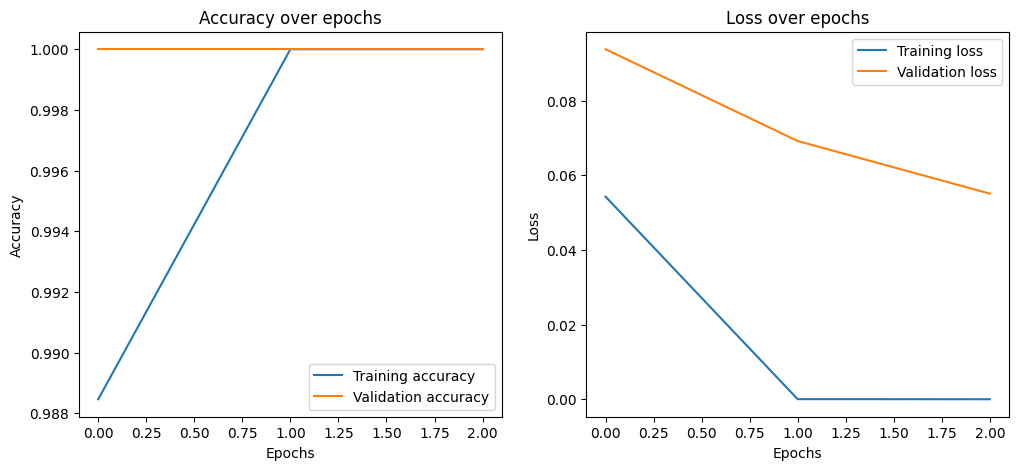

In [109]:
import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import *
from keras.models import *
from keras.utils import plot_model
from keras.preprocessing import sequence
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split

X_train, y_train = load_data()

# Hyper Parameters
time_step = 9000  # Đặt lại thời gian bước (số mẫu trong mỗi tín hiệu)
num_sensors = 1  # Số cảm biến
num_classes = 4  # Số lớp mục tiêu (4 lớp phân loại)
Batch_size = 32  # Kích thước batch
num_epoch = 3  # Số epoch huấn luyện

# Hàm chuẩn hóa
def normalize(v):
    return (v - v.mean(axis=1).reshape((v.shape[0], 1))) / (v.max(axis=1).reshape((v.shape[0], 1)) + 2e-12)

# Hàm chuyển đổi nhãn thành One-hot encoding
def convert2oneHot(index, Lens):
    hot = np.zeros((Lens,))  # Tạo mảng với tất cả giá trị là 0
    hot[index] = 1  # Đặt giá trị là 1 tại vị trí chỉ số của nhãn
    return hot

# Tạo ánh xạ nhãn thành chỉ số
label_mapping = {'N': 0, 'A': 1, 'O': 2, '~': 3}  # Thêm các nhãn và chỉ số tương ứng

# Hàm tạo dữ liệu batch cho huấn luyện
def xs_gen(X_data, y_data, batch_size=Batch_size):
    num_samples = X_data.shape[0]  # Số lượng mẫu
    steps = np.ceil(num_samples / batch_size).astype(int)  # Số bước (epochs)
    
    while True:
        for i in range(steps):
            # Lấy batch dữ liệu
            batch_x = X_data[i * batch_size: (i + 1) * batch_size]
            
            # Kiểm tra kiểu của nhãn trong y_data, đảm bảo rằng chúng là chuỗi
            batch_y = y_data[i * batch_size: (i + 1) * batch_size]
            # Nếu y_data chứa numpy array thay vì chuỗi, ta cần xử lý chúng thành chuỗi
            if isinstance(batch_y[0], np.ndarray):
                batch_y = np.array([label_mapping.get(str(label[0]), -1) for label in batch_y])  # Lấy chỉ số từ label_mapping
            else:
                batch_y = np.array([label_mapping.get(str(label), -1) for label in batch_y])  # Chuyển nhãn thành chuỗi và lấy chỉ số từ label_mapping

            # Chuyển đổi nhãn thành One-hot
            batch_y = np.array([convert2oneHot(label, num_classes) for label in batch_y])

            yield batch_x, batch_y

# Hàm vẽ đồ thị loss và accuracy
def plot_history(history):
    plt.figure(figsize=(12, 5))
    
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Hàm đánh giá precision và recall
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_class = np.argmax(y_pred, axis=1)  # Chuyển đổi dự đoán thành lớp
    y_test_class = np.argmax(y_test, axis=1)  # Chuyển đổi nhãn thực tế thành lớp
    
    accuracy = accuracy_score(y_test_class, y_pred_class)
    precision = precision_score(y_test_class, y_pred_class, average='weighted')
    recall = recall_score(y_test_class, y_pred_class, average='weighted')
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    return accuracy, precision, recall

if __name__ == "__main__":
    # Chia dữ liệu thành X_train và y_train, không cần chuẩn hóa
    # X_train giữ nguyên, chỉ thêm một chiều vào cuối để phù hợp với đầu vào của CNN
    X_train = np.expand_dims(X_train, axis=-1)

    # Chuyển y_train thành mảng numpy và thực hiện One-hot encoding
    y_train = np.array(y_train)  # Chuyển y_train thành mảng numpy nếu cần
    y_train = np.array([convert2oneHot(label_mapping[label], num_classes) for label in y_train])  # Chuyển y_train thành One-hot

    # Chia dữ liệu thành tập huấn luyện và tập xác thực
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    # Tạo các generator cho dữ liệu xác thực
    validation_iter = xs_gen(X_validation, y_validation, batch_size=Batch_size)

    # Tạo các generator cho dữ liệu huấn luyện
    train_iter = xs_gen(X_train, y_train, batch_size=Batch_size)

    # Xây dựng mô hình từ hàm build_model (hãy chắc chắn rằng hàm build_model được định nghĩa)
    model = build_model(time_step, num_sensors, num_classes)
    print(model.summary())  # In tóm tắt mô hình

    # Biên dịch mô hình với hàm mất mát và tối ưu hóa
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam', metrics=['accuracy'])  # Cấu hình mô hình

    # Huấn luyện mô hình
    history = model.fit(
        x=train_iter,  # Dữ liệu huấn luyện từ generator
        steps_per_epoch=X_train.shape[0] // Batch_size,  # Số bước trong mỗi epoch huấn luyện
        epochs=num_epoch,  # Số lượng epoch huấn luyện
        validation_data=validation_iter,  # Dữ liệu xác thực từ generator
        validation_steps=X_validation.shape[0] // Batch_size  # Số bước trong mỗi epoch xác thực
    )

    # Vẽ đồ thị accuracy và loss
    plot_history(history)

    # Đánh giá mô hình
    # evaluate_model(model, X_test, y_test)  # X_test và y_test là dữ liệu kiểm tra của bạn

# Làm trên tập test

In [97]:
zip_path = '/kaggle/working/EGC_dataset/sample2017.zip'
extract_to = '/kaggle/working/EGC_dataset_2017'
extract_zip_file(zip_path, extract_to)


Tệp đã được giải nén vào /kaggle/working/EGC_dataset_2017


In [102]:
def get_labels_test():
    dir = '/kaggle/working/EGC_dataset_2017/sample2017/validation/'
    label = pd.read_csv(dir + 'REFERENCE.csv')
    label = label.values.tolist() # --> convert test dataframe to list
    # print(label)
    y = np.array([])
    file = []
    for t in label:
            # print(t[1])
            y = np.append(y,t[1])
            file.append(t[0])
        # print(x)
    return y,file


    

In [103]:
y, file = get_labels_test()

In [106]:
def load_data_test():
    dir = '/kaggle/working/EGC_dataset_2017/sample2017/validation/'
    counter = 0

    # Lấy nhãn và danh sách file từ REFERENCE.csv
    y, f = get_labels_test()

    # Khởi tạo x_train, y_train
    x_train = []
    y_train = []

    # Duyệt qua từng file ID trong danh sách
    for i, file_id in enumerate(f):
        mat_file = os.path.join(dir, f"{file_id}.mat")  # Đường dẫn tới file .mat

        # Kiểm tra tệp có tồn tại không
        if os.path.exists(mat_file):
            try:
                # Đọc dữ liệu từ tệp .mat
                mat_data = loadmat(mat_file)

                # Lấy tín hiệu ECG từ biến "val"
                ecg_signal = mat_data["val"][0]  # Lấy hàng đầu tiên chứa tín hiệu

                # Kiểm tra độ dài tín hiệu (chỉ lấy tín hiệu đủ 9000 mẫu)
                if len(ecg_signal) == 9000:
                    x_train.append(ecg_signal)          # Thêm tín hiệu vào x_train
                    y_train.append(y[i])               # Thêm nhãn tương ứng vào y_train
                    counter += 1
                else:
                    # print(f"Tệp {file_id}.mat có độ dài tín hiệu không đủ 9000 mẫu.")
                    pass

            except Exception as e:
                print(f"Lỗi khi xử lý tệp {file_id}.mat: {e}")
        else:
            print(f"Tệp {file_id}.mat không tồn tại.")

    # Chuyển đổi x_train, y_train sang numpy array
    x_train = np.array(x_train)
    y_train = np.array(y_train)

    print(f"Tổng số tín hiệu hợp lệ: {counter}")
    return x_train, y_train

# ************************** End of Function *****************************************************

X_test, y_test = load_data_test()

print("Kích thước x_train:", X_test.shape)
print("Kích thước y_train:", y_test.shape)
print("Kết thúc")


Tổng số tín hiệu hợp lệ: 217
Kích thước x_train: (217, 9000)
Kích thước y_train: (217,)
Kết thúc


In [111]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix

X_test, y_test = load_data_test()

# Hàm chuyển đổi nhãn thành One-hot encoding
def convert2oneHot(index, Lens):
    hot = np.zeros((Lens,))  # Tạo mảng với tất cả giá trị là 0
    hot[index] = 1  # Đặt giá trị là 1 tại vị trí chỉ số của nhãn
    return hot

# Tạo ánh xạ nhãn thành chỉ số
label_mapping = {'N': 0, 'A': 1, 'O': 2, '~': 3}

# Hàm đánh giá mô hình
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_class = np.argmax(y_pred, axis=1)  # Chuyển đổi dự đoán thành lớp
    y_test_class = np.argmax(y_test, axis=1)  # Chuyển đổi nhãn thực tế thành lớp

    # Tính các chỉ số đánh giá
    accuracy = accuracy_score(y_test_class, y_pred_class)
    precision = precision_score(y_test_class, y_pred_class, average='weighted')
    recall = recall_score(y_test_class, y_pred_class, average='weighted')
    f1 = f1_score(y_test_class, y_pred_class, average='weighted')

    # In báo cáo chi tiết
    report = classification_report(y_test_class, y_pred_class, target_names=label_mapping.keys())
    print("Classification Report:")
    print(report)

    # Tạo confusion matrix
    cm = confusion_matrix(y_test_class, y_pred_class)
    print("Confusion Matrix:")
    print(cm)

    # Tạo DataFrame chứa kết quả
    results = pd.DataFrame({
        "Metric": ["Accuracy", "Precision", "Recall", "F1-Score"],
        "Score": [accuracy, precision, recall, f1]
    })

    return results, cm

if __name__ == "__main__":
    # Xử lý dữ liệu test, thêm một chiều vào cuối để phù hợp với đầu vào của CNN
    X_test = np.expand_dims(X_test, axis=-1)

    # Chuyển y_test thành One-hot nếu cần
    y_test = np.array([convert2oneHot(label_mapping[label], len(label_mapping)) for label in y_test])

    # Gọi hàm đánh giá mô hình
    results, cm = evaluate_model(model, X_test, y_test)

    # In bảng kết quả
    print("\nEvaluation Metrics:")
    print(results)

    # Lưu kết quả ra file CSV nếu cần
    results.to_csv("evaluation_metrics.csv", index=False)


Tổng số tín hiệu hợp lệ: 217
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step
Classification Report:
              precision    recall  f1-score   support

           N       0.00      0.00      0.00       113
           A       0.00      0.00      0.00        39
           O       0.00      0.00      0.00        52
           ~       0.06      1.00      0.11        13

    accuracy                           0.06       217
   macro avg       0.01      0.25      0.03       217
weighted avg       0.00      0.06      0.01       217

Confusion Matrix:
[[  0   0   0 113]
 [  0   0   0  39]
 [  0   0   0  52]
 [  0   0   0  13]]

Evaluation Metrics:
      Metric     Score
0   Accuracy  0.059908
1  Precision  0.003589
2     Recall  0.059908
3   F1-Score  0.006772


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:13